<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/MitelmanDB/Exploring_and_comparing_MitelmanDB_CytoConverter_and_TCGA_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring and comparing the Mitelman DB, CytoConverter, and TCGA datasets
Check out other notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

- **Title:** Exploring the Mitelman DB and CytoConverter datasets
- **Author:** Boris Aguilar, John Phan, Elaine Lee
- **Created:** 04-23-2022
- **Purpose:** Demonstrate basic usage of the Mitelman DB and CytoConverter datasets 

This notebook demonstrates basic usage of the Mitelman DB and CytoConverter datasets to explore chromosomal aberrations and compare then with the TCGA data for three well know chromosomal deletions: chromosome 1 in breast cancer, chromosome 3 in kidney adenocarcinoma, and chromosome 5 in acute myeloid leukemia.  

The Mitelman DB is hosted by ISB-CGC and can be accessed at this URL: https://mitelmandatabase.isb-cgc.org/. This notebook replicates some of the analyses from the paper by Denomy et al: https://cancerres.aacrjournals.org/content/79/20/5181. Note, however that results are not replicated exactly as some of the underlying data has changed since publication.  



# Initialize Notebook Environment

Before running the analysis, we need to load dependencies, authenticate to BigQuery, and customize notebook parameters.

### Import Dependencies

In [ ]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# Data Analytics
import numpy as np
from scipy import stats

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Authenticate

Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). Alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

In [ ]:
# If you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()

# alternatively, use the gcloud SDK
#!gcloud auth application-default login

### Google project ID

To run this notebook, you will need to have your Google Cloud Account set up. If you need to set up a Google Cloud Account, follow the "Obtain a Google identity" and "Set up a Google Cloud Project" steps on our [Quick-Start Guide documentation](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) page.

In [ ]:
# set the google project that will be billed for this notebook's computations
google_project = 'my_google_project_id' ## change me

## BigQuery Client

Create the BigQuery client.

In [ ]:
# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

# **1. Chromosomal gains and losses of breast cancer samples from Mitelman DB and TCGA data sets**

## Calculate Frequency of Gains and Losses in MitelmanDB Samples

We can use CytoConverter genomic coordinates to calculate the frequency of chromosomal gains and losses across a cohort of samples, e.g., across all breast cancer samples. 

In [ ]:
# Set parameters for this query
cancer_type = 'TCGA-BRCA' # Cancer type for TCGA
bq_project = 'mitelman-db'  # project name of Mitelman-DB BigQuery table
bq_dataset = 'prod' # Name of the dataset containing Mitelman-DB BigQuery tables
morphology = '3111' # Breast cancer
topology = '0401' # Adenocarcinoma

First, we identify all MitelmanDB cases related to the morphology and topology of interest. 

This query was copied from the new feature of the MitelmanDB interface: View Overall Gain/Loss in chromosome. 

In [ ]:
case_query = """
WITH cyto_cases AS (
 SELECT DISTINCT
 c.Refno,
 c.CaseNo,
 c.InvNo,
FROM
 `{bq_project}.{bq_dataset}.CytogenInvValid` c,
 `{bq_project}.{bq_dataset}.Reference` Reference,
 `{bq_project}.{bq_dataset}.Cytogen` Cytogen
LEFT JOIN `{bq_project}.{bq_dataset}.Koder` KoderM
ON
 (Cytogen.Morph = KoderM.Kod AND KoderM.KodTyp = 'MORPH')
LEFT JOIN `{bq_project}.{bq_dataset}.Koder` KoderT
ON
 (Cytogen.Topo = KoderT.Kod AND KoderT.KodTyp = 'TOP')
WHERE
 Cytogen.RefNo = c.RefNo
 AND Cytogen.CaseNo = c.CaseNo
 AND c.Refno = Reference.Refno
 AND Cytogen.Morph IN ('{morphology}')
 AND Cytogen.Topo IN ('{topology}')
),
SampleCount AS(

 SELECT COUNT(*) AS sCount
 FROM cyto_cases
),
Case_CC_Kary_Result AS (
 SELECT cc_result.*
 FROM cyto_cases
 LEFT JOIN `{bq_project}.{bq_dataset}.CytoConverted` AS cc_result
 ON cc_result.RefNo = cyto_cases.RefNo
 AND cc_result.caseNo = cyto_cases.caseNo
 AND cc_result.invNo = cyto_cases.invNo
),
Clone_imbal_sums AS (
 SELECT cytoBands.chromosome,
 cytoBands.cytoband_name,
 cytoBands.hg38_start,
 cytoBands.hg38_stop,
 Case_CC_Kary_Result.RefNo,
 Case_CC_Kary_Result.CaseNo,
 Case_CC_Kary_Result.InvNo,
 Case_CC_Kary_Result.Clone,
 SUM( CASE WHEN type = 'Gain' THEN 1 ELSE 0 END ) AS totalGain,
 SUM( CASE WHEN type = 'Loss' THEN 1 ELSE 0 END ) AS totalLoss
 FROM `{bq_project}.{bq_dataset}.CytoBands_hg38` AS cytoBands
 INNER JOIN Case_CC_Kary_Result
  ON cytoBands.chromosome = Case_CC_Kary_Result.Chr
 WHERE cytoBands.hg38_start >= Case_CC_Kary_Result.Start
 AND cytoBands.hg38_stop <= Case_CC_Kary_Result.End
 GROUP BY
 cytoBands.chromosome,
 cytoBands.cytoband_name,
 cytoBands.hg38_start,
 cytoBands.hg38_stop,
 Case_CC_Kary_Result.RefNo,
 Case_CC_Kary_Result.CaseNo,
 Case_CC_Kary_Result.InvNo,
 Case_CC_Kary_Result.Clone
),
AMP_DEL_counts AS (
 SELECT Clone_imbal_sums.chromosome, Clone_imbal_sums.cytoband_name, Clone_imbal_sums.hg38_start, Clone_imbal_sums.hg38_stop,
 Clone_imbal_sums.RefNo, Clone_imbal_sums.CaseNo, Clone_imbal_sums.InvNo, Clone_imbal_sums.Clone,
 CASE WHEN Clone_imbal_sums.totalGain > 1 THEN Clone_imbal_sums.totalGain ELSE 0 END AS amplified,
 CASE WHEN Clone_imbal_sums.totalLoss > 1 THEN Clone_imbal_sums.totalLoss ELSE 0 END AS hozy_deleted,
 CASE WHEN Clone_imbal_sums.totalGain > 1 THEN 1 ELSE 0 END AS amp_count,
 CASE WHEN Clone_imbal_sums.totalLoss > 1 THEN 1 ELSE 0 END AS hozy_del_count,
 FROM Clone_imbal_sums
),
Singular_imbal AS (
 SELECT Clone_imbal_sums.chromosome,
 Clone_imbal_sums.cytoband_name,
 Clone_imbal_sums.hg38_start,
 Clone_imbal_sums.hg38_stop,
 Clone_imbal_sums.RefNo,
 Clone_imbal_sums.CaseNo,
 Clone_imbal_sums.InvNo,
 Clone_imbal_sums.Clone,
 Clone_imbal_sums.totalGain - AMP_DEL_counts.amplified AS Singular_gain,
 Clone_imbal_sums.totalLoss - AMP_DEL_counts.hozy_deleted AS Singular_loss,
 AMP_DEL_counts.amp_count,
 AMP_DEL_counts.hozy_del_count
 FROM Clone_imbal_sums
 INNER JOIN AMP_DEL_counts
 ON Clone_imbal_sums.chromosome = AMP_DEL_counts.chromosome
 AND Clone_imbal_sums.cytoband_name = AMP_DEL_counts.cytoband_name
 AND Clone_imbal_sums.hg38_start= AMP_DEL_counts.hg38_start
 AND Clone_imbal_sums.hg38_stop = AMP_DEL_counts.hg38_stop
 AND Clone_imbal_sums.RefNo= AMP_DEL_counts.RefNo
 AND Clone_imbal_sums.CaseNo = AMP_DEL_counts.CaseNo
 AND Clone_imbal_sums.InvNo = AMP_DEL_counts.InvNo
 AND Clone_imbal_sums.Clone = AMP_DEL_counts.Clone
),
Sample_dist_count AS (
 SELECT Singular_imbal.chromosome,
 Singular_imbal.cytoband_name,
 Singular_imbal.hg38_start,
 Singular_imbal.hg38_stop,
 Singular_imbal.RefNo,
 Singular_imbal.CaseNo,
 Singular_imbal.InvNo,
 CASE WHEN SUM(Singular_imbal.Singular_gain)> 0 THEN 1 ELSE 0 END AS Sample_dist_singular_gain,
 CASE WHEN SUM(Singular_imbal.Singular_loss)> 0 THEN 1 ELSE 0 END AS Sample_dist_singular_loss,
 CASE WHEN SUM(Singular_imbal.amp_count)>0 THEN 1 ELSE 0 END AS Sample_dist_amp,
 CASE WHEN SUM(Singular_imbal.hozy_del_count)>0 THEN 1 ELSE 0 END AS Sample_dist_del,
 FROM Singular_imbal
 GROUP BY
 Singular_imbal.chromosome,
 Singular_imbal.cytoband_name,
 Singular_imbal.hg38_start,
 Singular_imbal.hg38_stop,
 Singular_imbal.RefNo,
 Singular_imbal.CaseNo,
 Singular_imbal.InvNo
)
SELECT Sample_dist_count.chromosome,
 CASE WHEN SUBSTRING(Sample_dist_count.chromosome, 4) = 'X' THEN 23
      WHEN SUBSTRING(Sample_dist_count.chromosome, 4) = 'Y' THEN 24
      ELSE CAST(SUBSTRING(Sample_dist_count.chromosome, 4) AS INT64)
 END AS chr_ord,
 Sample_dist_count.cytoband_name,
 Sample_dist_count.hg38_start,
 Sample_dist_count.hg38_stop,
 SampleCount.sCount,
 SUM(Sample_dist_count.Sample_dist_singular_gain) AS total_gain,
 SUM(Sample_dist_count.Sample_dist_singular_loss) AS total_loss,
 SUM(Sample_dist_count.Sample_dist_amp) AS total_amp,
 SUM(Sample_dist_count.Sample_dist_del) AS total_del,
 ROUND(SUM(Sample_dist_count.Sample_dist_singular_gain)/SampleCount.sCount*100, 2) AS gain_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_singular_loss)/SampleCount.sCount*100, 2) AS loss_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_amp)/SampleCount.sCount*100, 2) AS amp_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_del)/SampleCount.sCount*100, 2) AS del_freq
 FROM Sample_dist_count, SampleCount
 GROUP BY
 Sample_dist_count.chromosome,
 Sample_dist_count.cytoband_name,
 Sample_dist_count.hg38_start,
 Sample_dist_count.hg38_stop,
 SampleCount.sCount
 ORDER BY chr_ord, Sample_dist_count.hg38_start
""".format(
  bq_project=bq_project,
  bq_dataset=bq_dataset,
  morphology=morphology,
  topology=topology
)



In [ ]:
# Display the query
# print(case_query)

In [ ]:
# Run the query and put results in a data frame
final = client.query(case_query).result().to_dataframe()

# Display the table of cases
final

,chromosome,chr_ord,cytoband_name,hg38_start,hg38_stop,sCount,total_gain,total_loss,total_amp,total_del,gain_freq,loss_freq,amp_freq,del_freq
0,chr1,1,1p36,0,27600000,787,66,93,46,20,8.39,11.82,5.84,2.54
1,chr1,1,1p35,27600000,34300000,787,71,88,48,18,9.02,11.18,6.10,2.29
2,chr1,1,1p34,34300000,46300000,787,72,89,47,17,9.15,11.31,5.97,2.16
3,chr1,1,1p33,46300000,50200000,787,72,86,49,17,9.15,10.93,6.23,2.16
4,chr1,1,1p32,50200000,60800000,787,72,84,49,17,9.15,10.67,6.23,2.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,chrX,23,Xq27,138900000,148000000,787,72,94,46,3,9.15,11.94,5.84,0.38
316,chrX,23,Xq28,148000000,156040895,787,73,93,45,4,9.28,11.82,5.72,0.51
317,chrY,24,Yp11,0,10400000,787,0,8,0,0,0.00,1.02,0.00,0.00
318,chrY,24,Yq11,10400000,26600000,787,0,8,0,0,0.00,1.02,0.00,0.00


### Visualize Chromosomal Gains and Losses
We can now visualize the number of gains and losses for a specific chromosomal region across all samples in the Mitelman DB. 

We will visualize the number of amplifications (**amp:** gains of more than 1 copy), the number of gains (**gain:** gains of 1 extra copy), the number of losses (**loss:** loss of 1 copy) and the number of homozygous deletions (**del:** loss of the 2 copies). The x-axis represent the coordinate of the chromosome (in this case, chromosome 1). The y-axis represents the number of samples exhibiting an amplification. 

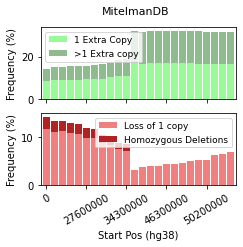

In [ ]:
ch1df = final[final.chromosome=='chr1'] 

fig, axes = plt.subplots(nrows=2, ncols=1) 
fig.set_size_inches(3.5,2.9)

positions = [0, 5, 10, 15, 20]

ax1 = ch1df.plot(ax = axes[0], kind='bar', stacked=True, 
           x="hg38_start", y=["gain_freq","amp_freq"] , color=['palegreen','darkseagreen'],
           width=0.9, rot=30, fontsize =10 )
ax1.set_ylabel('Frequency (%)',  fontsize = 10)
ax1.set_xlabel('')

ax1.set_xticks(positions)
ax1.xaxis.set_ticklabels([])

#ax1.set_xticks([])
ax1.legend(["1 Extra Copy", ">1 Extra copy"] , fontsize = 9)

ax2 = ch1df.plot(ax = axes[1], kind='bar', stacked=True, 
           x="hg38_start", y=["loss_freq","del_freq"] , color=['lightcoral','firebrick'],
           width=0.9, rot=30, fontsize =10 )
ax2.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax2.set_ylabel('Frequency (%)',  fontsize = 10)
ax2.set_xticks(positions)
ax2.legend(["Loss of 1 copy", "Homozygous Deletions"] , fontsize = 9)

fig.suptitle('MitelmanDB', fontsize=11)

fig.savefig('Frequencies_MitelmanDB_Kidney_chr3.png', dpi=300, bbox_inches = 'tight')
plt.show()

### Calculate Frequency of TCGA Copy Number Gains and Losses

As a comparison to MitelmanDB gain and loss frequency, we can calculate similar frequencies using TCGA Copy Number data. 

In [ ]:
cnv_query = """
WITH copy AS (
  SELECT case_barcode,	#sample_barcode,	aliquot_barcode, 
    chromosome,	start_pos,	end_pos,	MAX(copy_number) as copy_number
  FROM `isb-cgc-bq.TCGA_versioned.copy_number_segment_allelic_hg38_gdc_r23` 
  WHERE  project_short_name = '{tumor_type}'
  GROUP BY case_barcode, chromosome,	start_pos,	end_pos
),
total_cases AS (
  SELECT COUNT( DISTINCT case_barcode) as total
  FROM copy 
),
cytob AS (
  SELECT chromosome, cytoband_name, hg38_start, hg38_stop,
  FROM mitelman-db.prod.CytoBands_hg38
),
joined AS (
  SELECT cytob.chromosome, cytoband_name, hg38_start, hg38_stop,
    case_barcode,
    ( ABS(hg38_stop - hg38_start) + ABS(end_pos - start_pos) 
      - ABS(hg38_stop - end_pos) - ABS(hg38_start - start_pos) )/2.0  AS overlap ,
    copy_number  
  FROM copy
  LEFT JOIN cytob
  ON cytob.chromosome = copy.chromosome 
  WHERE 
    #cytob.hg38_start >= copy.start_pos AND cytob.hg38_start <= copy.end_pos  
    ( cytob.hg38_start >= copy.start_pos AND copy.end_pos >= cytob.hg38_start )
    OR ( copy.start_pos >= cytob.hg38_start  AND  copy.start_pos <= cytob.hg38_stop )
),
cbands AS(
SELECT chromosome, cytoband_name, hg38_start, hg38_stop, case_barcode,
    #ROUND( SUM(overlap*copy_number) / SUM(overlap) ) as copy_number
    #ARRAY_AGG( copy_number ORDER BY overlap DESC )[OFFSET(0)] as copy_number
    #ANY_VALUE(copy_number) as copy_number
    MAX(copy_number) as copy_number
    #MIN(copy_number) as copy_number
FROM joined
GROUP BY 
   chromosome, cytoband_name, hg38_start, hg38_stop, case_barcode
),
aberrations AS (
  SELECT
    chromosome,
    hg38_start,
    hg38_stop,
    -- Amplifications: more than two copies for diploid > 4
    SUM( IF (copy_number > 3 , 1 , 0) ) AS total_amp,
    -- Gains: at most two extra copies
    SUM( IF( copy_number = 3 ,1, 0) ) AS total_gain,
    -- Homozygous deletions, or complete deletions
    SUM( IF( copy_number = 0, 1, 0) ) AS total_homodel,
    -- Heterozygous deletions, 1 copy lost
    SUM( IF( copy_number = 1, 1, 0) ) AS total_heterodel,
    -- Normal for Diploid = 2
    SUM( IF( copy_number = 2, 1, 0) )  AS total_normal

  FROM cbands
  GROUP BY chromosome, cytoband_name, hg38_start, hg38_stop
)
SELECT chromosome, hg38_start, hg38_stop,
  total,  
  100 * total_amp / total as freq_amp, 
  100 * total_gain / total as freq_gain,
  100 * total_homodel/ total as freq_homodel, 
  100 * total_heterodel / total as freq_heterodel, 
  100 * total_normal / total as freq_normal  
FROM aberrations, total_cases
ORDER BY chromosome, hg38_start, hg38_stop
""".format( tumor_type = cancer_type)

In [ ]:
# Execute query and put results into a data frame
cnv = client.query(cnv_query).result().to_dataframe()

# Display table
cnv

,chromosome,hg38_start,hg38_stop,total,freq_amp,freq_gain,freq_homodel,freq_heterodel,freq_normal
0,chr1,0,27600000,1067,23.055295,23.149016,0.000000,7.966261,45.829428
1,chr1,27600000,34300000,1067,18.462980,22.305530,0.000000,7.310216,51.921275
2,chr1,34300000,46300000,1067,22.586692,21.930647,0.000000,5.342081,50.140581
3,chr1,46300000,50200000,1067,20.337395,21.555764,0.000000,5.716963,52.389878
4,chr1,50200000,60800000,1067,24.367385,20.149953,0.000000,5.529522,49.953140
...,...,...,...,...,...,...,...,...,...
300,chrX,138900000,148000000,1067,30.084349,14.058107,0.187441,9.278351,46.391753
301,chrX,148000000,156040895,1067,27.085286,16.869728,0.093721,9.278351,46.672915
302,chrY,0,10400000,1067,0.374883,0.281162,96.251172,2.811621,0.281162
303,chrY,10400000,26600000,1067,0.468604,0.281162,95.970009,2.999063,0.281162


### Plot frequencies from TCGA copy numbers 

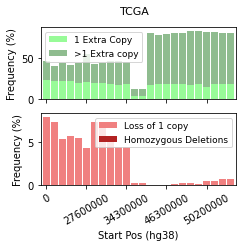

In [ ]:
ch1df = cnv[cnv.chromosome=='chr1'] 


fig, axes = plt.subplots(nrows=2, ncols=1) 
fig.set_size_inches(3.5,2.9)

positions = [0, 5, 10, 15, 20]

ax1 = ch1df.plot(ax = axes[0], kind='bar', stacked=True, 
           x="hg38_start", y=["freq_gain","freq_amp"] , color=['palegreen','darkseagreen'],
           width=0.9, rot=30, fontsize =10 )
ax1.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax1.set_ylabel('Frequency (%)',  fontsize = 10)
ax1.set_xlabel('')

ax1.set_xticks(positions)
ax1.xaxis.set_ticklabels([])
ax1.legend(["1 Extra Copy", ">1 Extra copy"] , fontsize = 9)

ax2 = ch1df.plot(ax = axes[1], kind='bar', stacked=True, 
           x="hg38_start", y=["freq_heterodel","freq_homodel"] , color=['lightcoral','firebrick'],
           width=0.9, rot=30, fontsize =10 )
ax2.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax2.set_ylabel('Frequency (%)',  fontsize = 10)
ax2.set_xticks(positions)
ax2.legend(["Loss of 1 copy", "Homozygous Deletions"] , fontsize = 9)

fig.suptitle('TCGA', fontsize=11)

fig.savefig('Frequencies_TCGA_Kidney_chr3.png', dpi=300, bbox_inches = 'tight')
plt.show()

# **2. Chromosomal gains and losses of kidney adenocarcinoma samples from Mitelman DB and TCGA datasets**

The steps to analyze kidney adenocarcinoma are similar to the previous example (breast cancer):

### Calculate Frequency of Gains and Losses in Mitelman DB Samples


In [ ]:
# Set parameters for this query
cancer_type = 'TCGA-KIRC' # Cancer type for TCGA
bq_project = 'mitelman-db'  # project name of Mitelman-DB BigQuery table
bq_dataset = 'prod' # Name of the dataset containing Mitelman-DB BigQuery tables
morphology = '3111' # Kidney
topology = '0301' # Adenocarcinoma

Identify all Mitelman DB cases related to the morphology and topology of interest.

In [ ]:
case_query = """
WITH cyto_cases AS (
 SELECT DISTINCT
 c.Refno,
 c.CaseNo,
 c.InvNo,
FROM
 `{bq_project}.{bq_dataset}.CytogenInvValid` c,
 `{bq_project}.{bq_dataset}.Reference` Reference,
 `{bq_project}.{bq_dataset}.Cytogen` Cytogen
LEFT JOIN `{bq_project}.{bq_dataset}.Koder` KoderM
ON
 (Cytogen.Morph = KoderM.Kod AND KoderM.KodTyp = 'MORPH')
LEFT JOIN `{bq_project}.{bq_dataset}.Koder` KoderT
ON
 (Cytogen.Topo = KoderT.Kod AND KoderT.KodTyp = 'TOP')
WHERE
 Cytogen.RefNo = c.RefNo
 AND Cytogen.CaseNo = c.CaseNo
 AND c.Refno = Reference.Refno
 AND Cytogen.Morph IN ('{morphology}')
 AND Cytogen.Topo IN ('{topology}')
),
SampleCount AS(

 SELECT COUNT(*) AS sCount
 FROM cyto_cases
),
Case_CC_Kary_Result AS (
 SELECT cc_result.*
 FROM cyto_cases
 LEFT JOIN `{bq_project}.{bq_dataset}.CytoConverted` AS cc_result
 ON cc_result.RefNo = cyto_cases.RefNo
 AND cc_result.caseNo = cyto_cases.caseNo
 AND cc_result.invNo = cyto_cases.invNo
),
Clone_imbal_sums AS (
 SELECT cytoBands.chromosome,
 cytoBands.cytoband_name,
 cytoBands.hg38_start,
 cytoBands.hg38_stop,
 Case_CC_Kary_Result.RefNo,
 Case_CC_Kary_Result.CaseNo,
 Case_CC_Kary_Result.InvNo,
 Case_CC_Kary_Result.Clone,
 SUM( CASE WHEN type = 'Gain' THEN 1 ELSE 0 END ) AS totalGain,
 SUM( CASE WHEN type = 'Loss' THEN 1 ELSE 0 END ) AS totalLoss
 FROM `{bq_project}.{bq_dataset}.CytoBands_hg38` AS cytoBands
 INNER JOIN Case_CC_Kary_Result
  ON cytoBands.chromosome = Case_CC_Kary_Result.Chr
 WHERE cytoBands.hg38_start >= Case_CC_Kary_Result.Start
 AND cytoBands.hg38_stop <= Case_CC_Kary_Result.End
 GROUP BY
 cytoBands.chromosome,
 cytoBands.cytoband_name,
 cytoBands.hg38_start,
 cytoBands.hg38_stop,
 Case_CC_Kary_Result.RefNo,
 Case_CC_Kary_Result.CaseNo,
 Case_CC_Kary_Result.InvNo,
 Case_CC_Kary_Result.Clone
),
AMP_DEL_counts AS (
 SELECT Clone_imbal_sums.chromosome, Clone_imbal_sums.cytoband_name, Clone_imbal_sums.hg38_start, Clone_imbal_sums.hg38_stop,
 Clone_imbal_sums.RefNo, Clone_imbal_sums.CaseNo, Clone_imbal_sums.InvNo, Clone_imbal_sums.Clone,
 CASE WHEN Clone_imbal_sums.totalGain > 1 THEN Clone_imbal_sums.totalGain ELSE 0 END AS amplified,
 CASE WHEN Clone_imbal_sums.totalLoss > 1 THEN Clone_imbal_sums.totalLoss ELSE 0 END AS hozy_deleted,
 CASE WHEN Clone_imbal_sums.totalGain > 1 THEN 1 ELSE 0 END AS amp_count,
 CASE WHEN Clone_imbal_sums.totalLoss > 1 THEN 1 ELSE 0 END AS hozy_del_count,
 FROM Clone_imbal_sums
),
Singular_imbal AS (
 SELECT Clone_imbal_sums.chromosome,
 Clone_imbal_sums.cytoband_name,
 Clone_imbal_sums.hg38_start,
 Clone_imbal_sums.hg38_stop,
 Clone_imbal_sums.RefNo,
 Clone_imbal_sums.CaseNo,
 Clone_imbal_sums.InvNo,
 Clone_imbal_sums.Clone,
 Clone_imbal_sums.totalGain - AMP_DEL_counts.amplified AS Singular_gain,
 Clone_imbal_sums.totalLoss - AMP_DEL_counts.hozy_deleted AS Singular_loss,
 AMP_DEL_counts.amp_count,
 AMP_DEL_counts.hozy_del_count
 FROM Clone_imbal_sums
 INNER JOIN AMP_DEL_counts
 ON Clone_imbal_sums.chromosome = AMP_DEL_counts.chromosome
 AND Clone_imbal_sums.cytoband_name = AMP_DEL_counts.cytoband_name
 AND Clone_imbal_sums.hg38_start= AMP_DEL_counts.hg38_start
 AND Clone_imbal_sums.hg38_stop = AMP_DEL_counts.hg38_stop
 AND Clone_imbal_sums.RefNo= AMP_DEL_counts.RefNo
 AND Clone_imbal_sums.CaseNo = AMP_DEL_counts.CaseNo
 AND Clone_imbal_sums.InvNo = AMP_DEL_counts.InvNo
 AND Clone_imbal_sums.Clone = AMP_DEL_counts.Clone
),
Sample_dist_count AS (
 SELECT Singular_imbal.chromosome,
 Singular_imbal.cytoband_name,
 Singular_imbal.hg38_start,
 Singular_imbal.hg38_stop,
 Singular_imbal.RefNo,
 Singular_imbal.CaseNo,
 Singular_imbal.InvNo,
 CASE WHEN SUM(Singular_imbal.Singular_gain)> 0 THEN 1 ELSE 0 END AS Sample_dist_singular_gain,
 CASE WHEN SUM(Singular_imbal.Singular_loss)> 0 THEN 1 ELSE 0 END AS Sample_dist_singular_loss,
 CASE WHEN SUM(Singular_imbal.amp_count)>0 THEN 1 ELSE 0 END AS Sample_dist_amp,
 CASE WHEN SUM(Singular_imbal.hozy_del_count)>0 THEN 1 ELSE 0 END AS Sample_dist_del,
 FROM Singular_imbal
 GROUP BY
 Singular_imbal.chromosome,
 Singular_imbal.cytoband_name,
 Singular_imbal.hg38_start,
 Singular_imbal.hg38_stop,
 Singular_imbal.RefNo,
 Singular_imbal.CaseNo,
 Singular_imbal.InvNo
)
SELECT Sample_dist_count.chromosome,
 CASE WHEN SUBSTRING(Sample_dist_count.chromosome, 4) = 'X' THEN 23
      WHEN SUBSTRING(Sample_dist_count.chromosome, 4) = 'Y' THEN 24
      ELSE CAST(SUBSTRING(Sample_dist_count.chromosome, 4) AS INT64)
 END AS chr_ord,
 Sample_dist_count.cytoband_name,
 Sample_dist_count.hg38_start,
 Sample_dist_count.hg38_stop,
 SampleCount.sCount,
 SUM(Sample_dist_count.Sample_dist_singular_gain) AS total_gain,
 SUM(Sample_dist_count.Sample_dist_singular_loss) AS total_loss,
 SUM(Sample_dist_count.Sample_dist_amp) AS total_amp,
 SUM(Sample_dist_count.Sample_dist_del) AS total_del,
 ROUND(SUM(Sample_dist_count.Sample_dist_singular_gain)/SampleCount.sCount*100, 2) AS gain_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_singular_loss)/SampleCount.sCount*100, 2) AS loss_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_amp)/SampleCount.sCount*100, 2) AS amp_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_del)/SampleCount.sCount*100, 2) AS del_freq
 FROM Sample_dist_count, SampleCount
 GROUP BY
 Sample_dist_count.chromosome,
 Sample_dist_count.cytoband_name,
 Sample_dist_count.hg38_start,
 Sample_dist_count.hg38_stop,
 SampleCount.sCount
 ORDER BY chr_ord, Sample_dist_count.hg38_start
""".format(
  bq_project=bq_project,
  bq_dataset=bq_dataset,
  morphology=morphology,
  topology=topology
)


In [ ]:
# Run the query and put results in a dataframe
final = client.query(case_query).result().to_dataframe()
final

,chromosome,chr_ord,cytoband_name,hg38_start,hg38_stop,sCount,total_gain,total_loss,total_amp,total_del,gain_freq,loss_freq,amp_freq,del_freq
0,chr1,1,1p36,0,27600000,1235,86,90,64,3,6.96,7.29,5.18,0.24
1,chr1,1,1p35,27600000,34300000,1235,87,75,67,3,7.04,6.07,5.43,0.24
2,chr1,1,1p34,34300000,46300000,1235,87,74,67,3,7.04,5.99,5.43,0.24
3,chr1,1,1p33,46300000,50200000,1235,86,69,67,3,6.96,5.59,5.43,0.24
4,chr1,1,1p32,50200000,60800000,1235,87,69,67,3,7.04,5.59,5.43,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,chrX,23,Xq27,138900000,148000000,1235,113,75,37,3,9.15,6.07,3.00,0.24
316,chrX,23,Xq28,148000000,156040895,1235,113,75,37,3,9.15,6.07,3.00,0.24
317,chrY,24,Yp11,0,10400000,1235,43,349,1,22,3.48,28.26,0.08,1.78
318,chrY,24,Yq11,10400000,26600000,1235,43,348,1,22,3.48,28.18,0.08,1.78


### Visualize Chromosomal Gains and Losses


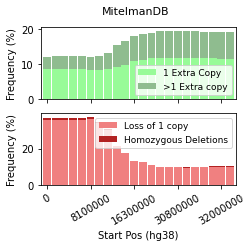

In [ ]:
ch1df = final[final.chromosome=='chr3'] 

fig, axes = plt.subplots(nrows=2, ncols=1) 
fig.set_size_inches(3.5,2.9)

positions = [0, 5, 10, 15, 20]

ax1 = ch1df.plot(ax = axes[0], kind='bar', stacked=True, 
           x="hg38_start", y=["gain_freq","amp_freq"] , color=['palegreen','darkseagreen'],
           width=0.9, rot=30, fontsize =10 )
ax1.set_ylabel('Frequency (%)',  fontsize = 10)
ax1.set_xlabel('')

ax1.set_xticks(positions)
ax1.xaxis.set_ticklabels([])

ax1.legend(["1 Extra Copy", ">1 Extra copy"] , fontsize = 9)

ax2 = ch1df.plot(ax = axes[1], kind='bar', stacked=True, 
           x="hg38_start", y=["loss_freq","del_freq"] , color=['lightcoral','firebrick'],
           width=0.9, rot=30, fontsize =10 )
ax2.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax2.set_ylabel('Frequency (%)',  fontsize = 10)
ax2.set_xticks(positions)
ax2.legend(["Loss of 1 copy", "Homozygous Deletions"] , fontsize = 9)

fig.suptitle('MitelmanDB', fontsize=11)

fig.savefig('Frequencies_MitelmanDB_Kidney_chr3.png', dpi=300, bbox_inches = 'tight')
plt.show()

### Calculate Frequency of TCGA Copy Number Gains and Losses


In [ ]:
cnv_query = """
WITH copy AS (
  SELECT case_barcode,	#sample_barcode,	aliquot_barcode, 
    chromosome,	start_pos,	end_pos,	MAX(copy_number) as copy_number
  FROM `isb-cgc-bq.TCGA_versioned.copy_number_segment_allelic_hg38_gdc_r23` 
  WHERE  project_short_name = '{tumor_type}'
  GROUP BY case_barcode, chromosome,	start_pos,	end_pos
),
total_cases AS (
  SELECT COUNT( DISTINCT case_barcode) as total
  FROM copy 
),
cytob AS (
  SELECT chromosome, cytoband_name, hg38_start, hg38_stop,
  FROM mitelman-db.prod.CytoBands_hg38
),
joined AS (
  SELECT cytob.chromosome, cytoband_name, hg38_start, hg38_stop,
    case_barcode,
    ( ABS(hg38_stop - hg38_start) + ABS(end_pos - start_pos) 
      - ABS(hg38_stop - end_pos) - ABS(hg38_start - start_pos) )/2.0  AS overlap ,
    copy_number  
  FROM copy
  LEFT JOIN cytob
  ON cytob.chromosome = copy.chromosome 
  WHERE 
    #cytob.hg38_start >= copy.start_pos AND cytob.hg38_start <= copy.end_pos  
    ( cytob.hg38_start >= copy.start_pos AND copy.end_pos >= cytob.hg38_start )
    OR ( copy.start_pos >= cytob.hg38_start  AND  copy.start_pos <= cytob.hg38_stop )
),
cbands AS(
SELECT chromosome, cytoband_name, hg38_start, hg38_stop, case_barcode,
    #ROUND( SUM(overlap*copy_number) / SUM(overlap) ) as copy_number
    #ARRAY_AGG( copy_number ORDER BY overlap DESC )[OFFSET(0)] as copy_number
    #ANY_VALUE(copy_number) as copy_number
    MAX(copy_number) as copy_number
    #MIN(copy_number) as copy_number
FROM joined
GROUP BY 
   chromosome, cytoband_name, hg38_start, hg38_stop, case_barcode
),
aberrations AS (
  SELECT
    chromosome,
    hg38_start,
    hg38_stop,
    -- Amplifications: more than two copies for diploid > 4
    SUM( IF (copy_number > 3 , 1 , 0) ) AS total_amp,
    -- Gains: at most two extra copies
    SUM( IF( copy_number = 3 ,1, 0) ) AS total_gain,
    -- Homozygous deletions, or complete deletions
    SUM( IF( copy_number = 0, 1, 0) ) AS total_homodel,
    -- Heterozygous deletions, 1 copy lost
    SUM( IF( copy_number = 1, 1, 0) ) AS total_heterodel,
    -- Normal for Diploid = 2
    SUM( IF( copy_number = 2, 1, 0) )  AS total_normal

  FROM cbands
  GROUP BY chromosome, cytoband_name, hg38_start, hg38_stop
)
SELECT chromosome, hg38_start, hg38_stop,
  total,  
  100 * total_amp / total as freq_amp, 
  100 * total_gain / total as freq_gain,
  100 * total_homodel/ total as freq_homodel, 
  100 * total_heterodel / total as freq_heterodel, 
  100 * total_normal / total as freq_normal  
FROM aberrations, total_cases
ORDER BY chromosome, hg38_start, hg38_stop
""".format( tumor_type = cancer_type)

In [ ]:
# Execute query and put results into a data frame
cnv = client.query(cnv_query).result().to_dataframe()

# Display table
cnv

,chromosome,hg38_start,hg38_stop,total,freq_amp,freq_gain,freq_homodel,freq_heterodel,freq_normal
0,chr1,0,27600000,517,18.568665,10.444874,0.000000,6.576402,64.410058
1,chr1,27600000,34300000,517,15.667311,8.123791,0.000000,6.769826,69.439072
2,chr1,34300000,46300000,517,17.021277,7.350097,0.000000,5.415861,70.212766
3,chr1,46300000,50200000,517,16.247582,7.156673,0.000000,5.609284,70.986460
4,chr1,50200000,60800000,517,18.375242,8.317215,0.000000,5.029014,68.278530
...,...,...,...,...,...,...,...,...,...
300,chrX,138900000,148000000,517,7.350097,3.094778,38.491296,24.564797,26.499033
301,chrX,148000000,156040895,517,9.671180,6.576402,17.794971,25.531915,40.425532
302,chrY,0,10400000,517,7.350097,5.996132,55.705996,7.350097,23.597679
303,chrY,10400000,26600000,517,8.123791,5.609284,55.899420,7.350097,23.017408


### Plot frequencies from TCGA copy numbers 

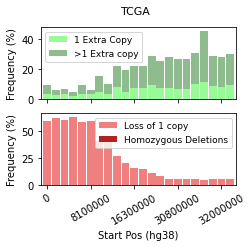

In [ ]:
# Chr 5 frequency of amplifications
ch1df = cnv[cnv.chromosome=='chr3'] 


fig, axes = plt.subplots(nrows=2, ncols=1) 
fig.set_size_inches(3.5,2.9)

positions = [0, 5, 10, 15, 20]

ax1 = ch1df.plot(ax = axes[0], kind='bar', stacked=True, 
           x="hg38_start", y=["freq_gain","freq_amp"] , color=['palegreen','darkseagreen'],
           width=0.9, rot=30, fontsize =10 )
ax1.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax1.set_ylabel('Frequency (%)',  fontsize = 10)
ax1.set_xlabel('')

ax1.set_xticks(positions)
ax1.xaxis.set_ticklabels([])
ax1.legend(["1 Extra Copy", ">1 Extra copy"] , fontsize = 9)

ax2 = ch1df.plot(ax = axes[1], kind='bar', stacked=True, 
           x="hg38_start", y=["freq_heterodel","freq_homodel"] , color=['lightcoral','firebrick'],
           width=0.9, rot=30, fontsize =10 )
ax2.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax2.set_ylabel('Frequency (%)',  fontsize = 10)
ax2.set_xticks(positions)
ax2.legend(["Loss of 1 copy", "Homozygous Deletions"] , fontsize = 9)

fig.suptitle('TCGA', fontsize=11)

#fig.savefig('Frequencies_TCGA_Kidney_chr3.png', dpi=300, bbox_inches = 'tight')
plt.show()


# **3. Chromosomal gains and losses of AML samples from Mitelman DB and TCGA datasets**

In [ ]:
# Set parameters for this query
cancer_type = 'TCGA-LAML' # Cancer type for TCGA
bq_project = 'mitelman-db'  # project name of Mitelman-DB BigQuery table
bq_dataset = 'prod' # Name of the dataset containing Mitelman-DB BigQuery tables
morphology = '11%' # Adenocarcinoma

In [ ]:
case_query = """
WITH cyto_cases AS (
 SELECT DISTINCT
 c.Refno,
 c.CaseNo,
 c.InvNo,
FROM
 `{bq_project}.{bq_dataset}.CytogenInvValid` c,
 `{bq_project}.{bq_dataset}.Reference` Reference,
 `{bq_project}.{bq_dataset}.Cytogen` Cytogen
LEFT JOIN `{bq_project}.{bq_dataset}.Koder` KoderM
ON
 (Cytogen.Morph = KoderM.Kod AND KoderM.KodTyp = 'MORPH')
LEFT JOIN `{bq_project}.{bq_dataset}.Koder` KoderT
ON
 (Cytogen.Topo = KoderT.Kod AND KoderT.KodTyp = 'TOP')
WHERE
 Cytogen.RefNo = c.RefNo
 AND Cytogen.CaseNo = c.CaseNo
 AND c.Refno = Reference.Refno
 AND Cytogen.Morph LIKE '{morphology}'
),
SampleCount AS(

 SELECT COUNT(*) AS sCount
 FROM cyto_cases
),
Case_CC_Kary_Result AS (
 SELECT cc_result.*
 FROM cyto_cases
 LEFT JOIN `{bq_project}.{bq_dataset}.CytoConverted` AS cc_result
 ON cc_result.RefNo = cyto_cases.RefNo
 AND cc_result.caseNo = cyto_cases.caseNo
 AND cc_result.invNo = cyto_cases.invNo
),
Clone_imbal_sums AS (
 SELECT cytoBands.chromosome,
 cytoBands.cytoband_name,
 cytoBands.hg38_start,
 cytoBands.hg38_stop,
 Case_CC_Kary_Result.RefNo,
 Case_CC_Kary_Result.CaseNo,
 Case_CC_Kary_Result.InvNo,
 Case_CC_Kary_Result.Clone,
 SUM( CASE WHEN type = 'Gain' THEN 1 ELSE 0 END ) AS totalGain,
 SUM( CASE WHEN type = 'Loss' THEN 1 ELSE 0 END ) AS totalLoss
 FROM `{bq_project}.{bq_dataset}.CytoBands_hg38` AS cytoBands
 INNER JOIN Case_CC_Kary_Result
  ON cytoBands.chromosome = Case_CC_Kary_Result.Chr
 WHERE cytoBands.hg38_start >= Case_CC_Kary_Result.Start
 AND cytoBands.hg38_stop <= Case_CC_Kary_Result.End
 GROUP BY
 cytoBands.chromosome,
 cytoBands.cytoband_name,
 cytoBands.hg38_start,
 cytoBands.hg38_stop,
 Case_CC_Kary_Result.RefNo,
 Case_CC_Kary_Result.CaseNo,
 Case_CC_Kary_Result.InvNo,
 Case_CC_Kary_Result.Clone
),
AMP_DEL_counts AS (
 SELECT Clone_imbal_sums.chromosome, Clone_imbal_sums.cytoband_name, Clone_imbal_sums.hg38_start, Clone_imbal_sums.hg38_stop,
 Clone_imbal_sums.RefNo, Clone_imbal_sums.CaseNo, Clone_imbal_sums.InvNo, Clone_imbal_sums.Clone,
 CASE WHEN Clone_imbal_sums.totalGain > 1 THEN Clone_imbal_sums.totalGain ELSE 0 END AS amplified,
 CASE WHEN Clone_imbal_sums.totalLoss > 1 THEN Clone_imbal_sums.totalLoss ELSE 0 END AS hozy_deleted,
 CASE WHEN Clone_imbal_sums.totalGain > 1 THEN 1 ELSE 0 END AS amp_count,
 CASE WHEN Clone_imbal_sums.totalLoss > 1 THEN 1 ELSE 0 END AS hozy_del_count,
 FROM Clone_imbal_sums
),
Singular_imbal AS (
 SELECT Clone_imbal_sums.chromosome,
 Clone_imbal_sums.cytoband_name,
 Clone_imbal_sums.hg38_start,
 Clone_imbal_sums.hg38_stop,
 Clone_imbal_sums.RefNo,
 Clone_imbal_sums.CaseNo,
 Clone_imbal_sums.InvNo,
 Clone_imbal_sums.Clone,
 Clone_imbal_sums.totalGain - AMP_DEL_counts.amplified AS Singular_gain,
 Clone_imbal_sums.totalLoss - AMP_DEL_counts.hozy_deleted AS Singular_loss,
 AMP_DEL_counts.amp_count,
 AMP_DEL_counts.hozy_del_count
 FROM Clone_imbal_sums
 INNER JOIN AMP_DEL_counts
 ON Clone_imbal_sums.chromosome = AMP_DEL_counts.chromosome
 AND Clone_imbal_sums.cytoband_name = AMP_DEL_counts.cytoband_name
 AND Clone_imbal_sums.hg38_start= AMP_DEL_counts.hg38_start
 AND Clone_imbal_sums.hg38_stop = AMP_DEL_counts.hg38_stop
 AND Clone_imbal_sums.RefNo= AMP_DEL_counts.RefNo
 AND Clone_imbal_sums.CaseNo = AMP_DEL_counts.CaseNo
 AND Clone_imbal_sums.InvNo = AMP_DEL_counts.InvNo
 AND Clone_imbal_sums.Clone = AMP_DEL_counts.Clone
),
Sample_dist_count AS (
 SELECT Singular_imbal.chromosome,
 Singular_imbal.cytoband_name,
 Singular_imbal.hg38_start,
 Singular_imbal.hg38_stop,
 Singular_imbal.RefNo,
 Singular_imbal.CaseNo,
 Singular_imbal.InvNo,
 CASE WHEN SUM(Singular_imbal.Singular_gain)> 0 THEN 1 ELSE 0 END AS Sample_dist_singular_gain,
 CASE WHEN SUM(Singular_imbal.Singular_loss)> 0 THEN 1 ELSE 0 END AS Sample_dist_singular_loss,
 CASE WHEN SUM(Singular_imbal.amp_count)>0 THEN 1 ELSE 0 END AS Sample_dist_amp,
 CASE WHEN SUM(Singular_imbal.hozy_del_count)>0 THEN 1 ELSE 0 END AS Sample_dist_del,
 FROM Singular_imbal
 GROUP BY
 Singular_imbal.chromosome,
 Singular_imbal.cytoband_name,
 Singular_imbal.hg38_start,
 Singular_imbal.hg38_stop,
 Singular_imbal.RefNo,
 Singular_imbal.CaseNo,
 Singular_imbal.InvNo
)
SELECT Sample_dist_count.chromosome,
 CASE WHEN SUBSTRING(Sample_dist_count.chromosome, 4) = 'X' THEN 23
      WHEN SUBSTRING(Sample_dist_count.chromosome, 4) = 'Y' THEN 24
      ELSE CAST(SUBSTRING(Sample_dist_count.chromosome, 4) AS INT64)
 END AS chr_ord,
 Sample_dist_count.cytoband_name,
 Sample_dist_count.hg38_start,
 Sample_dist_count.hg38_stop,
 SampleCount.sCount,
 SUM(Sample_dist_count.Sample_dist_singular_gain) AS total_gain,
 SUM(Sample_dist_count.Sample_dist_singular_loss) AS total_loss,
 SUM(Sample_dist_count.Sample_dist_amp) AS total_amp,
 SUM(Sample_dist_count.Sample_dist_del) AS total_del,
 ROUND(SUM(Sample_dist_count.Sample_dist_singular_gain)/SampleCount.sCount*100, 2) AS gain_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_singular_loss)/SampleCount.sCount*100, 2) AS loss_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_amp)/SampleCount.sCount*100, 2) AS amp_freq,
 ROUND(SUM(Sample_dist_count.Sample_dist_del)/SampleCount.sCount*100, 2) AS del_freq
 FROM Sample_dist_count, SampleCount
 GROUP BY
 Sample_dist_count.chromosome,
 Sample_dist_count.cytoband_name,
 Sample_dist_count.hg38_start,
 Sample_dist_count.hg38_stop,
 SampleCount.sCount
 ORDER BY chr_ord, Sample_dist_count.hg38_start
""".format(
  bq_project=bq_project,
  bq_dataset=bq_dataset,
  morphology=morphology
)

In [ ]:
# Run the query and put results in a data frame
final = client.query(case_query).result().to_dataframe()

# Display the table of cases
final

,chromosome,chr_ord,cytoband_name,hg38_start,hg38_stop,sCount,total_gain,total_loss,total_amp,total_del,gain_freq,loss_freq,amp_freq,del_freq
0,chr1,1,1p36,0,27600000,21109,352,341,280,9,1.67,1.62,1.33,0.04
1,chr1,1,1p35,27600000,34300000,21109,351,236,287,8,1.66,1.12,1.36,0.04
2,chr1,1,1p34,34300000,46300000,21109,351,227,287,8,1.66,1.08,1.36,0.04
3,chr1,1,1p33,46300000,50200000,21109,350,206,287,6,1.66,0.98,1.36,0.03
4,chr1,1,1p32,50200000,60800000,21109,353,211,288,6,1.67,1.00,1.36,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,chrX,23,Xq27,138900000,148000000,21109,406,776,90,2,1.92,3.68,0.43,0.01
316,chrX,23,Xq28,148000000,156040895,21109,406,788,90,2,1.92,3.73,0.43,0.01
317,chrY,24,Yp11,0,10400000,21109,253,1077,10,15,1.20,5.10,0.05,0.07
318,chrY,24,Yq11,10400000,26600000,21109,255,1077,10,15,1.21,5.10,0.05,0.07


### Visualize Chromosomal Gains and Losses


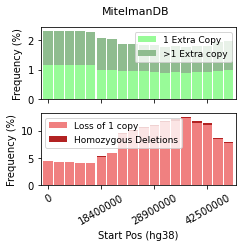

In [ ]:
ch1df = final[final.chromosome=='chr5'] 

fig, axes = plt.subplots(nrows=2, ncols=1) 
fig.set_size_inches(3.5,2.9)

positions = [0, 5, 10, 15]

ax1 = ch1df.plot(ax = axes[0], kind='bar', stacked=True, 
           x="hg38_start", y=["gain_freq","amp_freq"] , color=['palegreen','darkseagreen'],
           width=0.9, rot=45, fontsize =10 )
ax1.set_ylabel('Frequency (%)',  fontsize = 10)
ax1.set_xlabel('')

ax1.set_xticks(positions)
ax1.xaxis.set_ticklabels([])

#ax1.set_xticks([])
ax1.legend(["1 Extra Copy", ">1 Extra copy"] , fontsize = 9)

ax2 = ch1df.plot(ax = axes[1], kind='bar', stacked=True, 
           x="hg38_start", y=["loss_freq","del_freq"] , color=['lightcoral','firebrick'],
           width=0.9, rot=30, fontsize =10 )
ax2.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax2.set_ylabel('Frequency (%)',  fontsize = 10)
ax2.set_xticks(positions)
ax2.legend(["Loss of 1 copy", "Homozygous Deletions"] , fontsize = 9)

fig.suptitle('MitelmanDB', fontsize=11)

fig.savefig('Frequencies_MitelmanDB_AML_chr5.png', dpi=300, bbox_inches = 'tight')
plt.show()

### Calculate Frequency of TCGA Copy Number Gains and Losses

In [ ]:
cnv_query = """
WITH copy AS (
  SELECT case_barcode,	#sample_barcode,	aliquot_barcode, 
    chromosome,	start_pos,	end_pos,	MAX(copy_number) as copy_number
  FROM `isb-cgc-bq.TCGA_versioned.copy_number_segment_allelic_hg38_gdc_r23` 
  WHERE  project_short_name = '{cancer_type}'
  GROUP BY case_barcode, chromosome,	start_pos,	end_pos
),
total_cases AS (
  SELECT COUNT( DISTINCT case_barcode) as total
  FROM copy 
),
cytob AS (
  SELECT chromosome, cytoband_name, hg38_start, hg38_stop,
  FROM mitelman-db.prod.CytoBands_hg38
),
joined AS (
  SELECT cytob.chromosome, cytoband_name, hg38_start, hg38_stop,
    case_barcode,
    ( ABS(hg38_stop - hg38_start) + ABS(end_pos - start_pos) 
      - ABS(hg38_stop - end_pos) - ABS(hg38_start - start_pos) )/2.0  AS overlap ,
    copy_number  
  FROM copy
  LEFT JOIN cytob
  ON cytob.chromosome = copy.chromosome 
  WHERE 
    ( cytob.hg38_start >= copy.start_pos AND copy.end_pos >= cytob.hg38_start )
    OR ( copy.start_pos >= cytob.hg38_start  AND  copy.start_pos <= cytob.hg38_stop )
),
cbands AS(
SELECT chromosome, cytoband_name, hg38_start, hg38_stop, case_barcode,
    ROUND( SUM(overlap*copy_number) / SUM(overlap) ) as copy_number
FROM joined
GROUP BY 
   chromosome, cytoband_name, hg38_start, hg38_stop, case_barcode
),
aberrations AS (
  SELECT
    chromosome,
    hg38_start,
    hg38_stop,
    -- Amplifications: more than two copies for diploid > 4
    SUM( IF (copy_number > 3 , 1 , 0) ) AS total_amp,
    -- Gains: at most two extra copies
    SUM( IF( copy_number = 3 ,1, 0) ) AS total_gain,
    -- Homozygous deletions, or complete deletions
    SUM( IF( copy_number = 0, 1, 0) ) AS total_homodel,
    -- Heterozygous deletions, 1 copy lost
    SUM( IF( copy_number = 1, 1, 0) ) AS total_heterodel,
    -- Normal for Diploid = 2
    SUM( IF( copy_number = 2, 1, 0) )  AS total_normal

  FROM cbands
  GROUP BY chromosome, cytoband_name, hg38_start, hg38_stop
)
SELECT chromosome, hg38_start, hg38_stop,
  total,  
  100 * total_amp / total as freq_amp, 
  100 * total_gain / total as freq_gain,
  100 * total_homodel/ total as freq_homodel, 
  100 * total_heterodel / total as freq_heterodel, 
  100 * total_normal / total as freq_normal  
FROM aberrations, total_cases
ORDER BY chromosome, hg38_start, hg38_stop
""".format( cancer_type = cancer_type)

In [ ]:
# Execute query and put results into a data frame
cnv = client.query(cnv_query).result().to_dataframe()

# Display table
cnv

,chromosome,hg38_start,hg38_stop,total,freq_amp,freq_gain,freq_homodel,freq_heterodel,freq_normal
0,chr1,0,27600000,190,4.210526,2.631579,0.000000,0.000000,93.157895
1,chr1,27600000,34300000,190,4.736842,2.105263,0.000000,0.000000,93.157895
2,chr1,34300000,46300000,190,4.736842,2.105263,0.000000,0.000000,93.157895
3,chr1,46300000,50200000,190,4.736842,2.105263,0.000000,0.000000,93.157895
4,chr1,50200000,60800000,190,4.736842,2.105263,0.000000,0.000000,93.157895
...,...,...,...,...,...,...,...,...,...
300,chrX,138900000,148000000,190,2.105263,0.000000,22.105263,33.684211,42.105263
301,chrX,148000000,156040895,190,2.105263,0.000000,21.578947,34.210526,42.105263
302,chrY,0,10400000,190,2.105263,3.684211,47.368421,0.526316,46.315789
303,chrY,10400000,26600000,190,2.105263,3.684211,47.894737,0.000000,46.315789


### Plot frequencies from TCGA copy numbers 

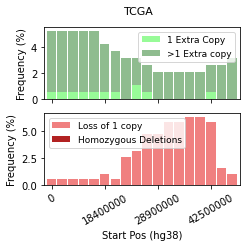

In [ ]:
# Chr 5 frequency of amplifications
ch1df = cnv[cnv.chromosome=='chr5'] 


fig, axes = plt.subplots(nrows=2, ncols=1) 
fig.set_size_inches(3.5,2.9)

positions = [0, 5, 10, 15]

ax1 = ch1df.plot(ax = axes[0], kind='bar', stacked=True, 
           x="hg38_start", y=["freq_gain","freq_amp"] , color=['palegreen','darkseagreen'],
           width=0.9, rot=30, fontsize =10 )
ax1.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax1.set_ylabel('Frequency (%)',  fontsize = 10)
ax1.set_xlabel('')

ax1.set_xticks(positions)
ax1.xaxis.set_ticklabels([])
ax1.legend(["1 Extra Copy", ">1 Extra copy"] , fontsize = 9)

ax2 = ch1df.plot(ax = axes[1], kind='bar', stacked=True, 
           x="hg38_start", y=["freq_heterodel","freq_homodel"] , color=['lightcoral','firebrick'],
           width=0.9, rot=30, fontsize =10 )
ax2.set_xlabel('Start Pos (hg38)',  fontsize=10)
ax2.set_ylabel('Frequency (%)',  fontsize = 10)
ax2.set_xticks(positions)
ax2.legend(["Loss of 1 copy", "Homozygous Deletions"] , fontsize = 9)

fig.suptitle('TCGA', fontsize=11)

fig.savefig('Frequencies_TCGA_AML_chr5.png', dpi=300, bbox_inches = 'tight')
plt.show()

# **4. Conclusion**

This notebook demonstrated usage of the Mitelman DB in BigQuery, which includes CytoConverter chromosomal coordinate data, for basic exploration and analysis of chromosomal aberrations and gene fusions.

We observed that the frequency of gains and losses across samples in the TCGA and Mitelman DB are correlated in three know chromosomal deleteion: chromosome 1 in breast cancer, chromosome 3 in kidney adenocarcinoma, and chromosome 5 in acute myeloid leukemia. Some of these results are concordant with those of the Denomy et al. 